# Análise das notas de corte do Prouni 2018

In [321]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import pi

sns.set(font_scale=1.5)
pd.set_option('display.max_columns', 130)
pd.set_option('display.max_rows', 130)

In [351]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [2]:
df = pd.read_csv('cursos_prouni.csv')
df.head()

,uf_busca,cidade_busca,universidade_nome,campus_nome,nome,grau,turno,mensalidade,bolsa_integral_cotas,bolsa_integral_ampla,bolsa_parcial_cotas,bolsa_parcial_ampla,nota_integral_ampla,nota_integral_cotas,nota_parcial_ampla,nota_parcial_cotas
0,AC,Acrelandia,Universidade Paulista - UNIP,ACRELANDIA - Centro,Administração,Bacharelado,Curso a Distância,289.0,1.0,1.0,NaN,NaN,572.74,548.0,NaN,NaN
1,AC,Cruzeiro do Sul,Centro Universitário Internacional - Uninter -...,PAP CRUZEIRO DO SUL - Centro,Administração,Bacharelado,Curso a Distância,298.0,1.0,NaN,NaN,NaN,646.14,NaN,NaN,NaN
2,AC,Cruzeiro do Sul,Faculdade Educacional da Lapa - FAEL,AC - CRUZEIRO DO SUL - POLO EAD - CENTRO,Administração,Bacharelado,Curso a Distância,325.0,NaN,NaN,1.0,NaN,NaN,NaN,577.62,NaN
3,AC,Cruzeiro do Sul,Universidade Paulista - UNIP,CRUZEIRO DO SUL - Centro,Administração,Bacharelado,Curso a Distância,319.0,1.0,NaN,NaN,NaN,616.68,NaN,NaN,NaN
4,AC,Rio Branco,Centro Universitário Internacional - Uninter -...,PAP RIO BRANCO - Bosque,Administração,Bacharelado,Curso a Distância,298.0,NaN,NaN,1.0,NaN,NaN,NaN,569.00,NaN


## 0. Adaptando a base de dados

In [165]:
bolsas = ['bolsa_integral_ampla', 'bolsa_integral_cotas', 'bolsa_parcial_cotas', 'bolsa_parcial_ampla']
notas = ['nota_integral_ampla', 'nota_integral_cotas', 'nota_parcial_cotas', 'nota_parcial_ampla']

In [214]:
# Regiões do país
estados_reg = {
    'RO': 'Norte',
    'AC': 'Norte',
    'AM': 'Norte',
    'RR': 'Norte',
    'PA': 'Norte',
    'AP': 'Norte',
    'TO': 'Norte',
    'MA': 'Nordeste',
    'PI': 'Nordeste',
    'CE': 'Nordeste',
    'RN': 'Nordeste',
    'PB': 'Nordeste',
    'PE': 'Nordeste',
    'AL': 'Nordeste',
    'SE': 'Nordeste',
    'BA': 'Nordeste',
    'MG': 'Sudeste',
    'ES': 'Sudeste',
    'RJ': 'Sudeste',
    'SP': 'Sudeste',
    'PR': 'Sul',
    'SC': 'Sul',
    'RS': 'Sul',
    'MS': 'Centro-Oeste',
    'MT': 'Centro-Oeste',
    'GO': 'Centro-Oeste',
    'DF': 'Centro-Oeste',
}
uf_regiao = pd.DataFrame.from_dict(estados_reg, orient='index', columns=['regiao']).reset_index().rename(columns={'index': 'uf'})
uf_regiao.head()

,uf,regiao
0,RO,Norte
1,AC,Norte
2,AM,Norte
3,RR,Norte
4,PA,Norte


In [223]:
# Estendendo df
df['total_bolsas'] = df[bolsas].sum(axis=1)
df['nota_media'] = df[notas].mean(axis=1) # Será usado apenas como "score", para ter uma noção aproximada do valor cobrado por certa faculdade 

# Versão diminuída do df, apenas com infos mais relevantes - será usado em breve
dfmin = df.drop(columns=['campus_nome']+bolsas+notas, axis=1)
dfmin.rename(columns={'uf_busca': 'uf', 'cidade_busca': 'cidade', 'universidade_nome': 'universidade', 'nome': 'curso'}, inplace=True)
dfmin = pd.merge(dfmin, uf_regiao, on='uf')

# Reordenando cols
cols = dfmin.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfmin = dfmin[cols]

dfmin.head()

,regiao,uf,cidade,universidade,curso,grau,turno,mensalidade,total_bolsas,nota_media
0,Norte,AC,Acrelandia,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,289.0,2.0,560.37
1,Norte,AC,Cruzeiro do Sul,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,646.14
2,Norte,AC,Cruzeiro do Sul,Faculdade Educacional da Lapa - FAEL,Administração,Bacharelado,Curso a Distância,325.0,1.0,577.62
3,Norte,AC,Cruzeiro do Sul,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,319.0,1.0,616.68
4,Norte,AC,Rio Branco,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,569.00


# 1. Análise exploratória de dados

In [3]:
# Avaliamos os tipos e a qtd de nulls em cada variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41447 entries, 0 to 41446
Data columns (total 16 columns):
uf_busca                41447 non-null object
cidade_busca            41447 non-null object
universidade_nome       41447 non-null object
campus_nome             41447 non-null object
nome                    41447 non-null object
grau                    41447 non-null object
turno                   41447 non-null object
mensalidade             41447 non-null float64
bolsa_integral_cotas    32520 non-null float64
bolsa_integral_ampla    25404 non-null float64
bolsa_parcial_cotas     8828 non-null float64
bolsa_parcial_ampla     13041 non-null float64
nota_integral_ampla     32520 non-null float64
nota_integral_cotas     16802 non-null float64
nota_parcial_ampla      16350 non-null float64
nota_parcial_cotas      5519 non-null float64
dtypes: float64(9), object(7)
memory usage: 5.1+ MB


In [90]:
# Possibilidades nas variáveis categóricas
df[['uf_busca', 'cidade_busca', 'universidade_nome', 'campus_nome', 'nome', 'grau', 'turno']].nunique()

uf_busca               27
cidade_busca         1158
universidade_nome    1299
campus_nome          4774
nome                  296
grau                    3
turno                   5
dtype: int64

In [4]:
# Check de consistência: todas as faculdades listadas aqui têm ao menos uma bolsa? Se 0, sim.
len(df.loc[((df['bolsa_integral_cotas'] < 1) | (df['bolsa_integral_cotas'].isna())) & 
           ((df['bolsa_integral_ampla'] < 1) | (df['bolsa_integral_ampla'].isna())) & 
           ((df['bolsa_parcial_cotas'] < 1) | (df['bolsa_parcial_cotas'].isna())) & 
           ((df['bolsa_parcial_ampla'] < 1) | (df['bolsa_parcial_ampla'].isna()))])

0

## Comparação entre os tipos de bolsas
<br></br>
Em geral, as faculdades privadas oferecem poucas bolsas, parciais e integrais, de ampla concorrência ou com cotas: suas medianas giram entre **1 e 2 bolsas/faculdade** no período considerado. 
<br></br><br></br>
Um fato interessante é que **bolsas parciais de ampla concorrência** possuem uma variância cerca de 50 vezes maior do que as outras modalidades de bolsa. Nesse nesse universo de 41 mil instituições, isto pode significar que uma parcela considerável é formada por pequenas unidades de negócio, que equilibram o fluxo de caixa com a concorrência com outras faculdades atraindo alunos com bolsas parciais e mensalidades baixas. 

In [98]:
df[bolsas].describe()

,bolsa_integral_ampla,bolsa_integral_cotas,bolsa_parcial_cotas,bolsa_parcial_ampla
count,25404.000000,32520.000000,8828.000000,13041.000000
mean,2.513541,1.535394,1.873018,8.632544
std,3.019549,2.191578,2.336403,18.372991
min,1.000000,0.000000,1.000000,1.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,6.000000
max,67.000000,58.000000,74.000000,350.000000


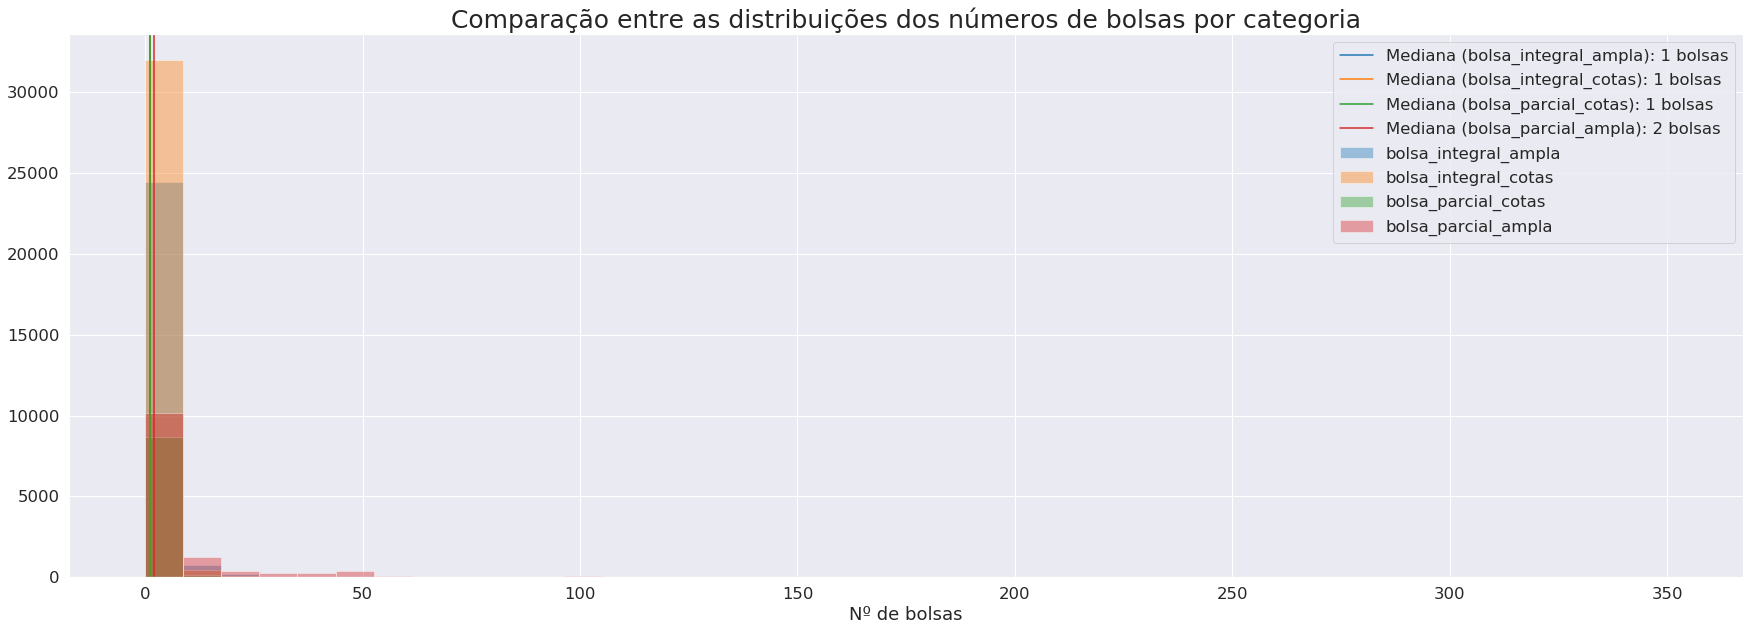

In [99]:
sns.set(font_scale=1.5)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(30, 10))
plt.title('Comparação entre as distribuições dos números de bolsas por categoria', size=25)
for b, c in zip(bolsas, colors):
    sns.distplot(df[b], bins=40, norm_hist=False, kde=False, hist_kws={'range':(0,350)}, color=c, label=b)
    plt.axvline(x=df[b].median(), color=c, label='Mediana ({0}): {1:.0f} bolsas'.format(b, df[b].median()))

plt.xlabel('Nº de bolsas')
plt.legend()
plt.show()

## Análise das mensalidades
<br>
Visão geral da distribuição das mensalidades, sem separação por grupos.
<br>
Nota: o histograma abaixo originalmente vai até R$ 10k. Limitamos para facilitar a visualização.

In [133]:
df['mensalidade'].describe()

count    41447.000000
mean       622.636966
std        606.442296
min        139.000000
25%        278.000000
50%        393.350000
75%        825.000000
max       9999.990000
Name: mensalidade, dtype: float64

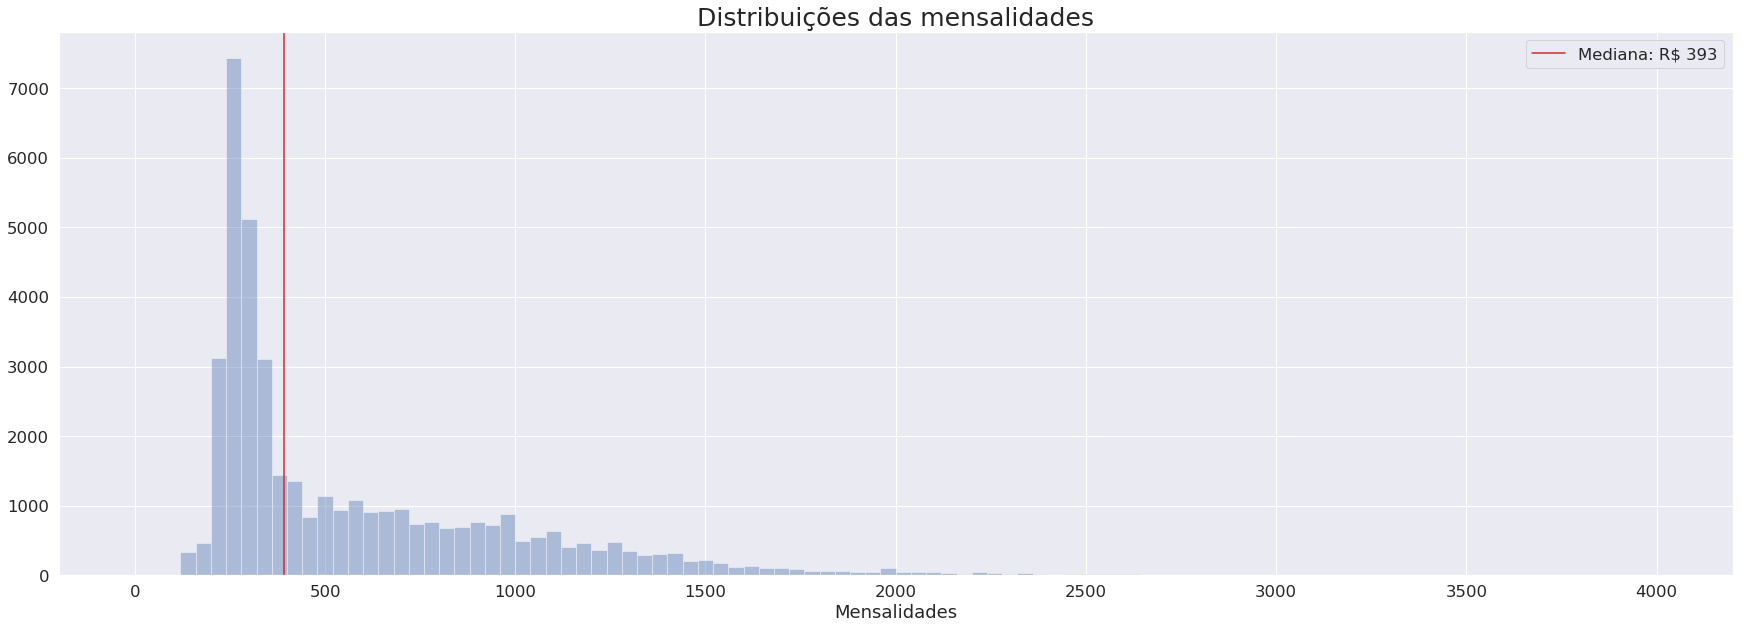

In [132]:
sns.set(font_scale=1.5)

plt.figure(figsize=(30, 10))
plt.title('Distribuições das mensalidades', size=25)

sns.distplot(df['mensalidade'], bins=100, norm_hist=False, kde=False, hist_kws={'range':(0,4000)})
plt.axvline(x=df['mensalidade'].median(), color=c, label='Mediana: R$ {:.0f}'.format(df['mensalidade'].median()))

plt.xlabel('Mensalidades')
plt.legend()
plt.show()

## Comparação entre as notas de corte

In [96]:
df[notas].describe()

,nota_integral_ampla,nota_integral_cotas,nota_parcial_cotas,nota_parcial_ampla
count,32520.000000,16802.000000,5519.000000,16350.000000
mean,575.982999,564.470439,511.799638,527.517136
std,57.827594,57.869145,56.787140,60.202170
min,450.000000,450.000000,450.000000,450.000000
25%,544.360000,532.865000,450.000000,453.980000
50%,580.740000,571.450000,511.820000,532.420000
75%,614.145000,603.315000,557.170000,573.235000
max,781.200000,792.240000,768.340000,776.360000


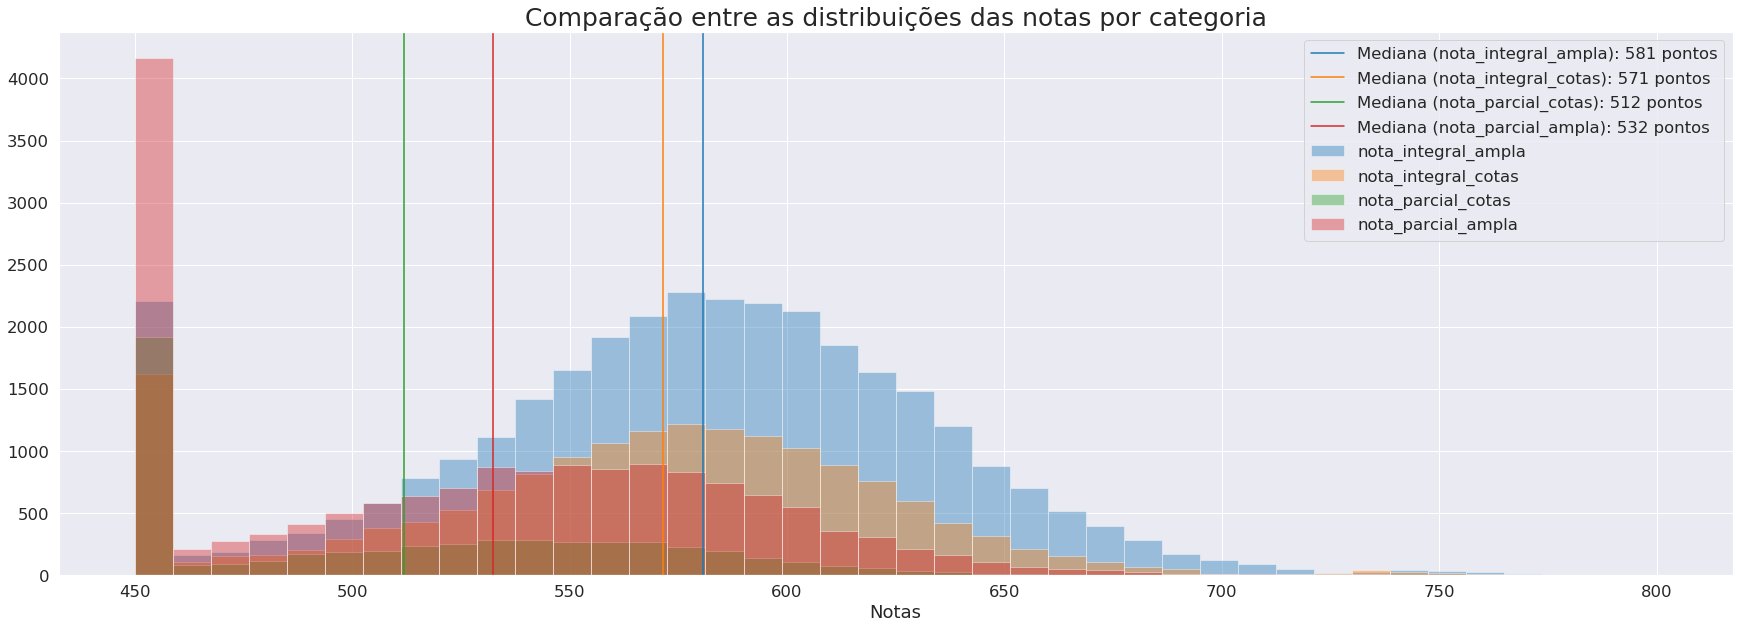

In [97]:
sns.set(font_scale=1.5)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(30, 10))
plt.title('Comparação entre as distribuições das notas por categoria', size=25)
for n, c in zip(notas, colors):
    sns.distplot(df[n], bins=40, norm_hist=False, kde=False, hist_kws={'range':(450,800)}, color=c, label=n)
    plt.axvline(x=df[n].median(), color=c, label='Mediana ({0}): {1:.0f} pontos'.format(n, df[n].median()))

plt.xlabel('Notas')
plt.legend()
plt.show()

Na sobreposição de histogramas acima, podemos ver que, em todos as categorias de nota de corte, há um elevado número de notas cravado em **450, a nota mínima para poder se candidatar ao Prouni**. Qual o tamanho desse grupo? Vamos avaliar as faculdades nas quais: 
- Todas as notas de corte são 450;
- Pelo menos uma das notas é 450.

Ao cabo, como suas mensalidades se comparam ao do restante das faculdades?

In [128]:
# Todas as notas de corte iguais a 450
equal450 = df.loc[(df[notas[0]]==450) & (df[notas[1]]==450) & (df[notas[2]]==450) & (df[notas[3]]==450)]['mensalidade']
100*len(equal450)/len(df)

0.07720703549110913

In [391]:
uma450 = df.loc[(df[notas[0]]==450) | (df[notas[1]]==450) | (df[notas[2]]==450) | (df[notas[3]]==450)]['mensalidade']
100*len(uma450)/len(df)

18.2667020532246

In [392]:
dif450 = df.loc[(df[notas[0]]!=450) & (df[notas[1]]!=450) & (df[notas[2]]!=450) & (df[notas[3]]!=450)]['mensalidade']
100*len(dif450)/len(df)

81.7332979467754

De fato, as mensalidades os grupos de universidades com todas as notas iguais a 450 ou pelo menos uma delas 450, comparados com aquelas universidades (maioria), onde nenhuma das notas é a mínima, são diferentes:

In [394]:
stats.ttest_ind(equal450, dif450, equal_var=False, nan_policy='raise')

Ttest_indResult(statistic=-6.5901547718752465, pvalue=2.1393674146990006e-07)

In [393]:
stats.ttest_ind(uma450, dif450, equal_var=False, nan_policy='raise')

Ttest_indResult(statistic=-38.60281078024576, pvalue=0.0)

E podemos perceber que as faculdades com notas mínimas têm, também, mensalidades mais baixas:

In [396]:
equal450.describe()

count      32.000000
mean      407.170000
std       216.880067
min       189.000000
25%       263.817500
50%       414.780000
75%       414.780000
max      1042.140000
Name: mensalidade, dtype: float64

In [399]:
uma450.describe()

count    7571.000000
mean      451.532428
std       361.104575
min       144.000000
25%       260.270000
50%       298.000000
75%       499.000000
max      6180.000000
Name: mensalidade, dtype: float64

In [398]:
dif450.describe()

count    33876.000000
mean       660.877385
std        642.513403
min        139.000000
25%        288.000000
50%        443.000000
75%        880.500000
max       9999.990000
Name: mensalidade, dtype: float64

## Análise excluindo grupo dos 450
Obtemos curvas normais excluindo o grupo com notas de corte de 450.

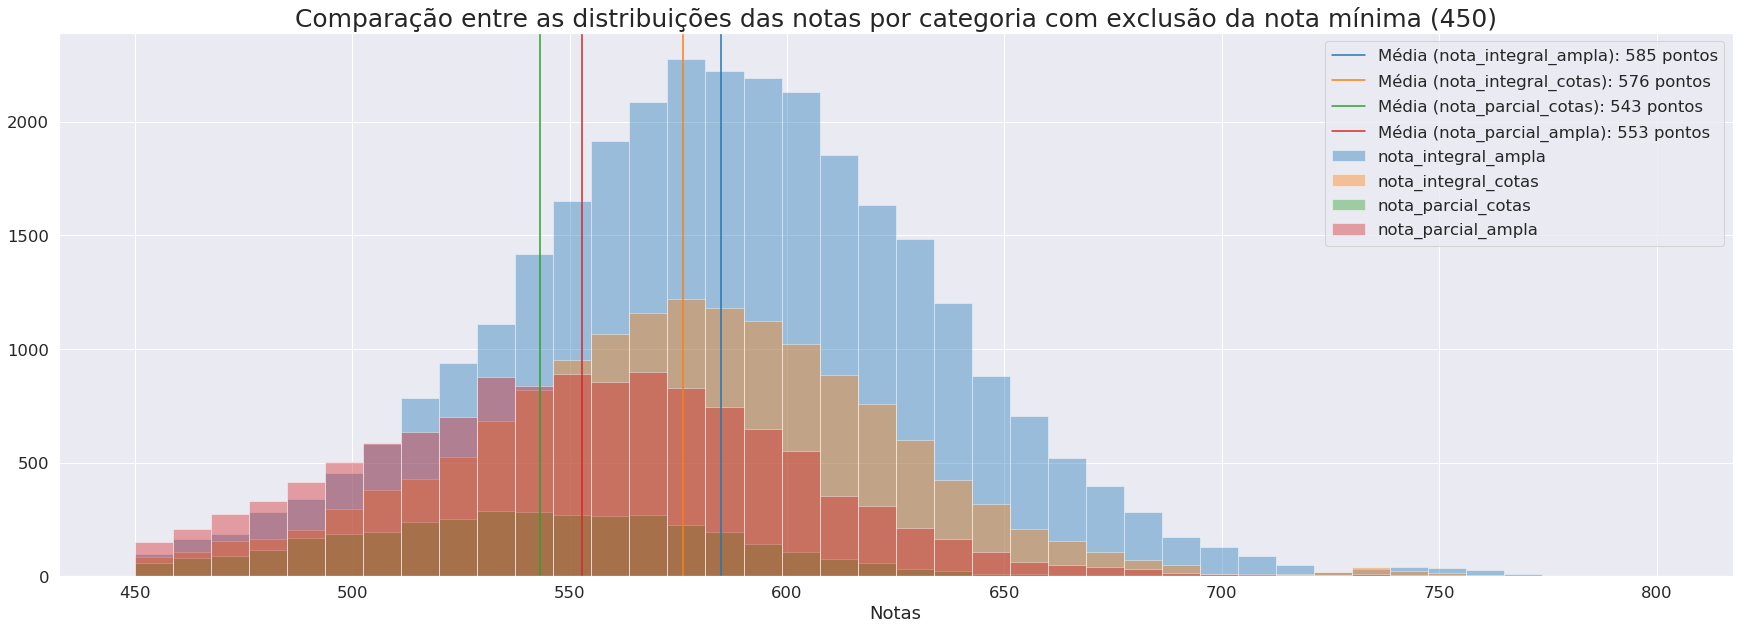

In [100]:
sns.set(font_scale=1.5)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(30, 10))
plt.title('Comparação entre as distribuições das notas por categoria com exclusão da nota mínima (450)', size=25)
for n, c in zip(notas, colors):
    sns.distplot(df.loc[df[n]>450][n], bins=40, norm_hist=False, kde=False, hist_kws={'range':(450,800)}, color=c, label=n)
    plt.axvline(x=df.loc[df[n]>450][n].mean(), color=c, label='Média ({0}): {1:.0f} pontos'.format(n, df.loc[df[n]>450][n].mean()))

plt.xlabel('Notas')
plt.legend()
plt.show()

In [385]:
# Testes de normalidade e de diferença entre médias
int_cotas = df.loc[df['nota_integral_cotas']>450]['nota_integral_cotas']
int_ampla = df.loc[df['nota_integral_ampla']>450]['nota_integral_ampla']
parc_cotas = df.loc[df['nota_parcial_cotas']>450]['nota_parcial_cotas']
parc_ampla = df.loc[df['nota_parcial_ampla']>450]['nota_parcial_ampla']

Teste de normalidade

In [88]:
stats.shapiro(int_cotas)

/home/turing/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9937139749526978, 3.7039223380280465e-25)

In [386]:
stats.shapiro(int_ampla)

/home/turing/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9977500438690186, 2.1180550889311278e-20)

In [387]:
stats.shapiro(parc_cotas)

(0.9837133288383484, 3.962593861033647e-20)

In [388]:
stats.shapiro(parc_ampla)

/home/turing/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.991866946220398, 7.509064035102583e-26)

In [79]:
df[notas].describe()

,nota_integral_cotas,nota_integral_ampla,nota_parcial_cotas,nota_parcial_ampla
count,16802.000000,32520.000000,5519.000000,16350.000000
mean,564.470439,575.982999,511.799638,527.517136
std,57.869145,57.827594,56.787140,60.202170
min,450.000000,450.000000,450.000000,450.000000
25%,532.865000,544.360000,450.000000,453.980000
50%,571.450000,580.740000,511.820000,532.420000
75%,603.315000,614.145000,557.170000,573.235000
max,792.240000,781.200000,768.340000,776.360000


As médias são distintas?


T-test para compará-las (integrais com integrais e parciais com parciais)

In [389]:
# Notas integrais
stats.ttest_ind(int_ampla, int_cotas, equal_var=False, nan_policy='raise')

Ttest_indResult(statistic=18.4583820544839, pvalue=1.119344937169767e-75)

In [390]:
# Notas parciais
stats.ttest_ind(parc_ampla, parc_cotas, equal_var=False, nan_policy='raise')

Ttest_indResult(statistic=11.411269738658806, pvalue=7.175713935294578e-30)

Apesar das grandes variâncias, as notas são, como esperado, distintas.

## 2. Cursos mais populares

In [304]:
dfmin.head()

,regiao,uf,cidade,universidade,curso,grau,turno,mensalidade,total_bolsas,nota_media
0,Norte,AC,Acrelandia,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,289.0,2.0,560.37
1,Norte,AC,Cruzeiro do Sul,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,646.14
2,Norte,AC,Cruzeiro do Sul,Faculdade Educacional da Lapa - FAEL,Administração,Bacharelado,Curso a Distância,325.0,1.0,577.62
3,Norte,AC,Cruzeiro do Sul,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,319.0,1.0,616.68
4,Norte,AC,Rio Branco,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,569.00


In [309]:
cursos = dfmin.groupby(['curso', 'turno']) \
                    .agg({'mensalidade': 'median',
                          'total_bolsas': 'count',
                          'nota_media': 'mean'}) \
                    .rename(columns={'mensalidade': 'mensalidade_mediana'}) \
                    .reset_index() \
                    .sort_values(by='total_bolsas', ascending=False)
cursos.head()

,curso,turno,mensalidade_mediana,total_bolsas,nota_media
559,Pedagogia,Curso a Distância,285.00,1855,526.480364
0,Administração,Curso a Distância,298.00,1504,546.789660
85,Ciências Contábeis,Curso a Distância,298.00,1245,548.488810
424,Gestão de Recursos Humanos,Curso a Distância,279.00,1142,524.490397
3,Administração,Noturno,722.77,915,568.817220


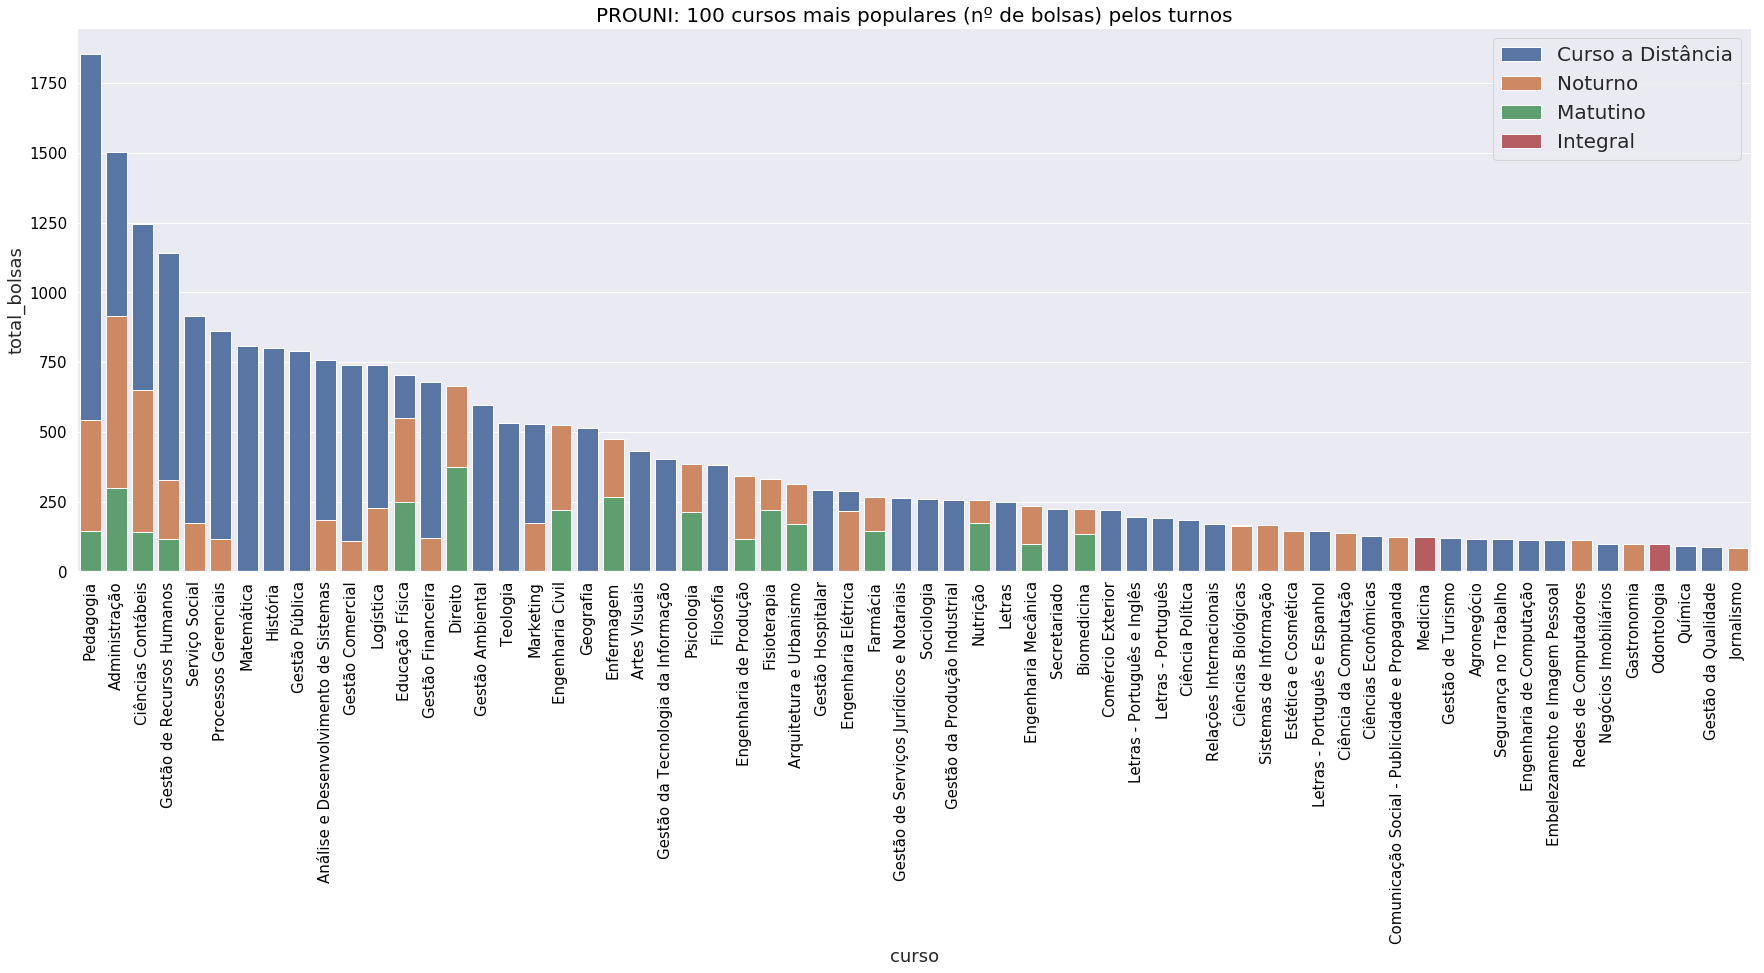

In [314]:
sns.set(font_scale=1.5)
plt.figure(figsize=(30, 10))

plt.title('PROUNI: 100 cursos mais populares (nº de bolsas) pelos turnos', color='black', size=20)

plt.xticks(color='black', size=15, rotation=90)
plt.yticks(color='black', size=15)

sns.barplot(x='curso', y='total_bolsas', data=cursos.head(100), hue='turno', dodge=False)

plt.legend(fontsize=20, loc=1)
plt.show()

## Comparação entre os 3 cursos mais populares
São eles:
- Pedagogia
- Administração
- Ciências Contábeis

In [379]:
cursos_princ = dfmin.groupby(['curso']) \
                    .agg({'mensalidade': 'median',
                          'total_bolsas': 'count',
                          'nota_media': 'mean'}) \
                    .rename(columns={'mensalidade': 'mensalidade_mediana'}) \
                    .reset_index() \
                    .sort_values(by='total_bolsas', ascending=False)
cursos_princ = cursos_princ.loc[cursos_princ['curso'].isin(['Pedagogia', 'Administração', 'Ciências Contábeis'])]
cursos_princ.reset_index(drop=True, inplace=True)
cursos_princ['total_bolsas'] = cursos_princ['total_bolsas'].astype(float)

cursos_princ.head()

,curso,mensalidade_mediana,total_bolsas,nota_media
0,Administração,393.675,2754.0,556.434696
1,Pedagogia,308.000,2555.0,532.622385
2,Ciências Contábeis,333.000,2056.0,558.209288


In [380]:
# Normalizando colunas
cursos_princ[['mensalidade_mediana', 'total_bolsas', 'nota_media']] = normalize(cursos_princ.drop(columns='curso', axis=1))

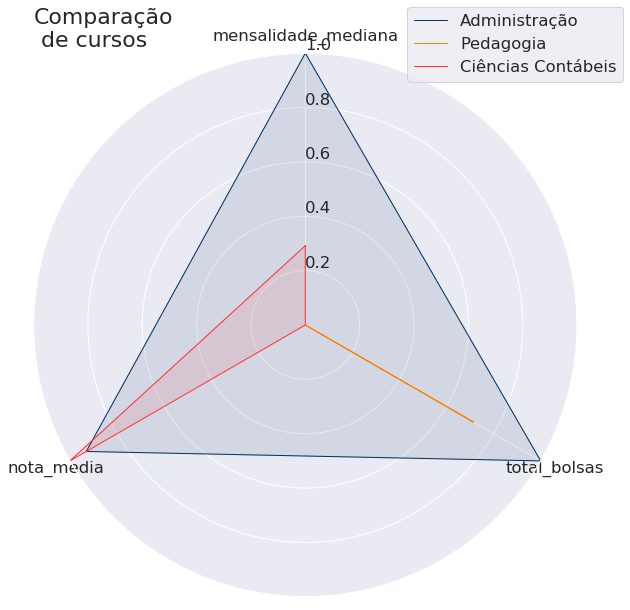

In [384]:
plt.figure(figsize=(50, 10))
categories=list(cursos_princ)[1:]
N = len(categories)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
 
# Desenha ylabels
ax.set_rlabel_position(0)
plt.ylim(0,1)

# Ind1
values=cursos_princ.loc[0].drop('curso').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Administração', color='#003366')
ax.fill(angles, values, 'b', alpha=0.1, color='#003366')
 
# Ind2
values=cursos_princ.loc[1].drop('curso').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Pedagogia', color='#FF8000')
ax.fill(angles, values, 'r', alpha=0.1, color='#FF8000')

# Ind3
values=cursos_princ.loc[2].drop('curso').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Ciências Contábeis', color='#FF3333')
ax.fill(angles, values, 'r', alpha=0.1, color='#FF3333')
 
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Comparação\n de cursos', loc='left', size=22)

plt.show()

# 3. Análise geográfica

## Comparação entre regiões do país

In [251]:
comp_regioes = dfmin.groupby('regiao') \
                    .agg({'mensalidade': 'median',
                          'total_bolsas': 'count',
                          'nota_media': 'mean'}) \
                    .rename(columns={'mensalidade': 'mensalidade_mediana'}) \
                    .reset_index()
comp_regioes.head()

,regiao,mensalidade_mediana,total_bolsas,nota_media
0,Centro-Oeste,329.00,4189,542.330455
1,Nordeste,522.50,7141,576.290224
2,Norte,325.00,2969,563.645764
3,Sudeste,418.35,17975,553.136733
4,Sul,329.00,9173,538.960535


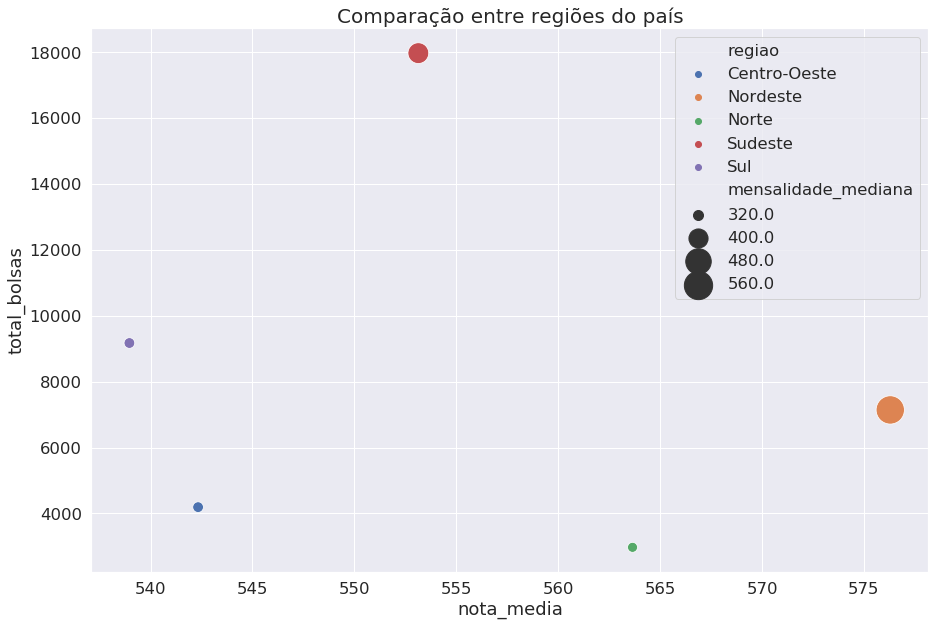

In [263]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
plt.title('Comparação entre regiões do país', size=20)

sns.scatterplot(x='nota_media', y='total_bolsas',
                data=comp_regioes,
                sizes=(100, 800),
                hue='regiao',
                size='mensalidade_mediana', legend='brief')

No gráfico acima pode notar que, sob a tripla nº de bolsas, notas de corte e mensalidades, as 5 regiões do país se distinguem bastante:
- O Sudeste e o Nordeste se assemelham nas altas mensalidades, mas as notas de corte no último são cerca de 10% mais elevadas;
- Inversamente, o Nordeste dispõe de muito menos bolsas (60% a menos) do que o Sudeste, o que se explica pela população menor e, talvez, considerando as altas mensalidades, por uma maior concentração de mercado nas mãos de poucos players;
- Centro-Oeste e Sul são as regiões mais fáceis de passar no país;
- Numa posição meso, o Norte se destaca com notas de corte maiores do que o Sudeste.

## Comparação entre estados

In [260]:
comp_estados = dfmin.groupby(['regiao', 'uf']) \
                    .agg({'mensalidade': 'median',
                          'total_bolsas': 'count',
                          'nota_media': 'mean'}) \
                    .rename(columns={'mensalidade': 'mensalidade_mediana'}) \
                    .reset_index()
comp_estados.head()

,regiao,uf,mensalidade_mediana,total_bolsas,nota_media
0,Centro-Oeste,DF,587.39,1063,563.813913
1,Centro-Oeste,GO,333.00,1278,548.863856
2,Centro-Oeste,MS,319.00,785,527.642605
3,Centro-Oeste,MT,325.00,1063,523.838788
4,Nordeste,AL,403.23,327,582.716351


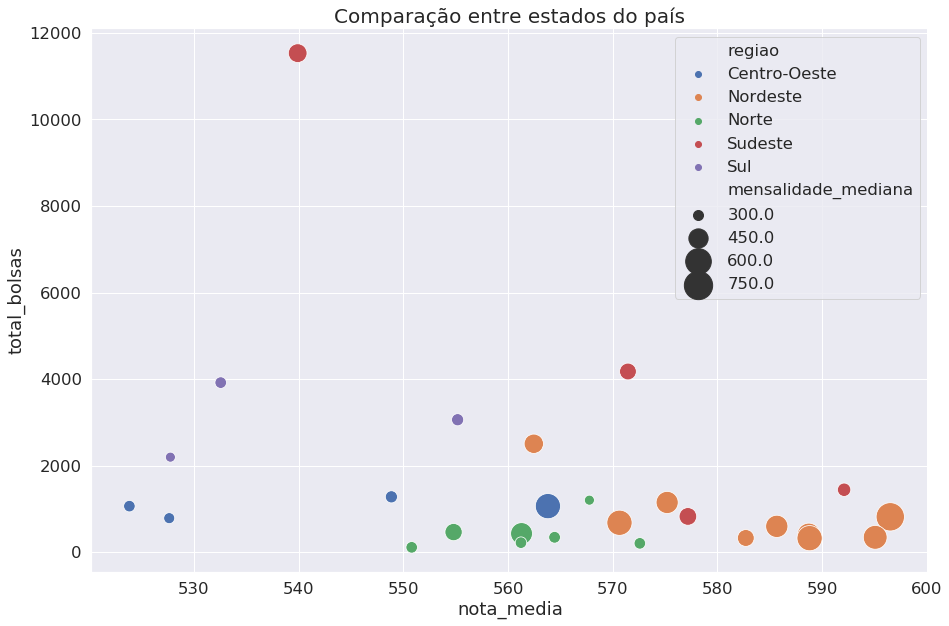

In [264]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
plt.title('Comparação entre estados do país', size=20)

sns.scatterplot(x='nota_media', y='total_bolsas',
                data=comp_estados,
                sizes=(100, 800),
                hue='regiao',
                size='mensalidade_mediana', legend='brief')

Acima podemos notar que os estados do nordeste possuem as maiores notas de corte do país, bem como altas mensalidades. Considerando as condições econômicas desfavoráveis da região, isto possivelmente se explica por uma baixa entrada no ensino superior público (e, claro, a uma insuficiência de instituições desse tipo) e, simultaneamente, uma nova fronteira de exploração de mercado pela iniciativa privada - provavelmente há, ainda, poucos players no mercado, o que faz as mensalidades aumentarem, ao mesmo tempo que o rigor da seleção, proporcionalmente, também aumenta. 

In [155]:
mean_estados = df.groupby('uf_busca').mean().reset_index()
mean_estados.head()

,uf_busca,mensalidade,bolsa_integral_cotas,bolsa_integral_ampla,bolsa_parcial_cotas,bolsa_parcial_ampla,nota_integral_ampla,nota_integral_cotas,nota_parcial_ampla,nota_parcial_cotas
0,AC,570.743645,1.528662,1.236364,2.338583,1.588235,592.320255,597.901887,567.295556,560.335584
1,AL,534.481284,2.547445,1.777174,1.791209,2.619048,598.094599,587.339457,559.630435,545.240000
2,AM,576.651958,3.400576,2.000000,2.037736,21.763158,580.413199,568.020102,526.945128,537.891667
3,AP,578.471918,3.114943,1.625000,1.643836,1.625000,583.807126,571.523469,527.139744,528.025455
4,BA,639.848802,2.348121,1.902778,2.701396,13.628289,588.942140,580.011162,524.612396,506.756225


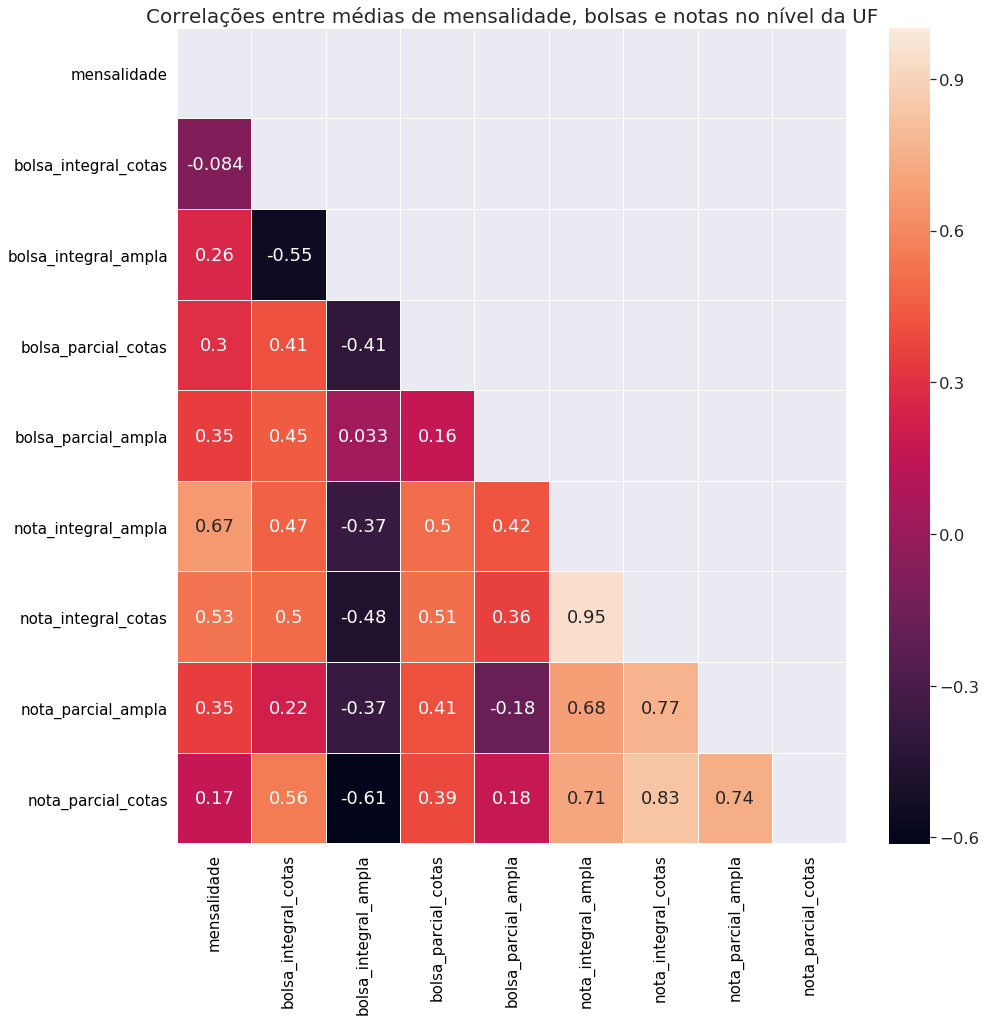

In [156]:
sns.set(font_scale=1.5)
mask = np.zeros_like(mean_estados.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))
plt.title('Correlações entre médias de mensalidade, bolsas e notas no nível da UF', size=20)
sns.heatmap(mean_estados.corr(), mask=mask, annot=True, linecolor='white', linewidths=0.1)
plt.xticks(color='black', size=15, rotation=90)
plt.yticks(color='black', size=15)
plt.show()

## Comparação entre municípios

In [267]:
dfmin.head()

,regiao,uf,cidade,universidade,curso,grau,turno,mensalidade,total_bolsas,nota_media
0,Norte,AC,Acrelandia,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,289.0,2.0,560.37
1,Norte,AC,Cruzeiro do Sul,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,646.14
2,Norte,AC,Cruzeiro do Sul,Faculdade Educacional da Lapa - FAEL,Administração,Bacharelado,Curso a Distância,325.0,1.0,577.62
3,Norte,AC,Cruzeiro do Sul,Universidade Paulista - UNIP,Administração,Bacharelado,Curso a Distância,319.0,1.0,616.68
4,Norte,AC,Rio Branco,Centro Universitário Internacional - Uninter -...,Administração,Bacharelado,Curso a Distância,298.0,1.0,569.00


In [268]:
comp_cidades = dfmin.groupby(['regiao', 'uf', 'cidade']) \
                    .agg({'mensalidade': 'median',
                          'total_bolsas': 'count',
                          'nota_media': 'mean'}) \
                    .rename(columns={'mensalidade': 'mensalidade_mediana'}) \
                    .reset_index()
comp_cidades.head()

,regiao,uf,cidade,mensalidade_mediana,total_bolsas,nota_media
0,Centro-Oeste,DF,Brasilia,587.39,1063,563.813913
1,Centro-Oeste,GO,Aguas Lindas de Goias,600.00,35,507.034476
2,Centro-Oeste,GO,Alexania,209.00,7,498.278571
3,Centro-Oeste,GO,Alto Horizonte,571.32,5,450.000000
4,Centro-Oeste,GO,Anapolis,678.07,81,595.386790


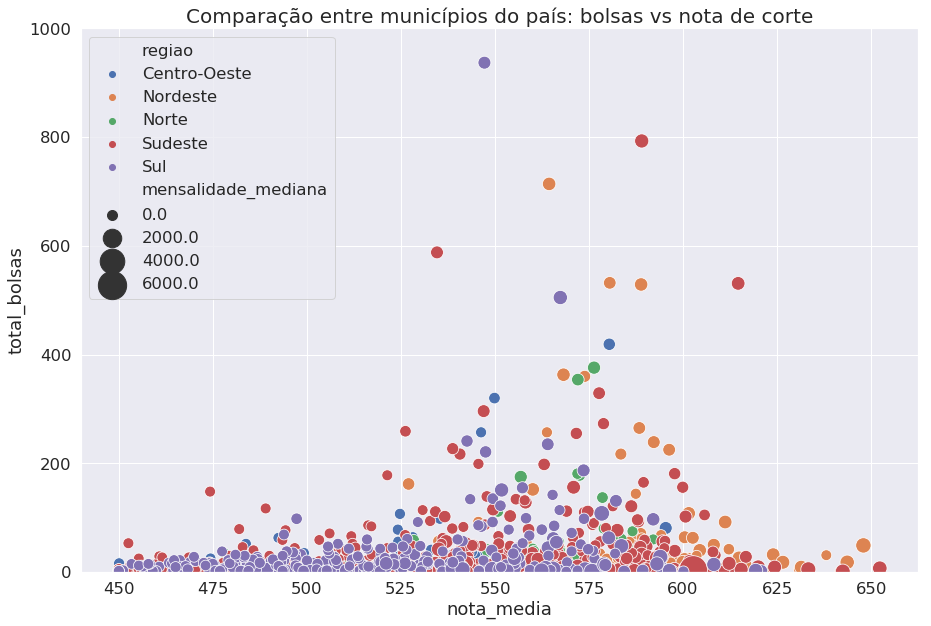

In [291]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
plt.title('Comparação entre municípios do país: bolsas vs nota de corte', size=20)

sns.scatterplot(x='nota_media', y='total_bolsas',
                data=comp_cidades,
                sizes=(100, 800),
                hue='regiao',
                size='mensalidade_mediana', 
                legend='brief')
plt.ylim(0, 1000)
plt.show()

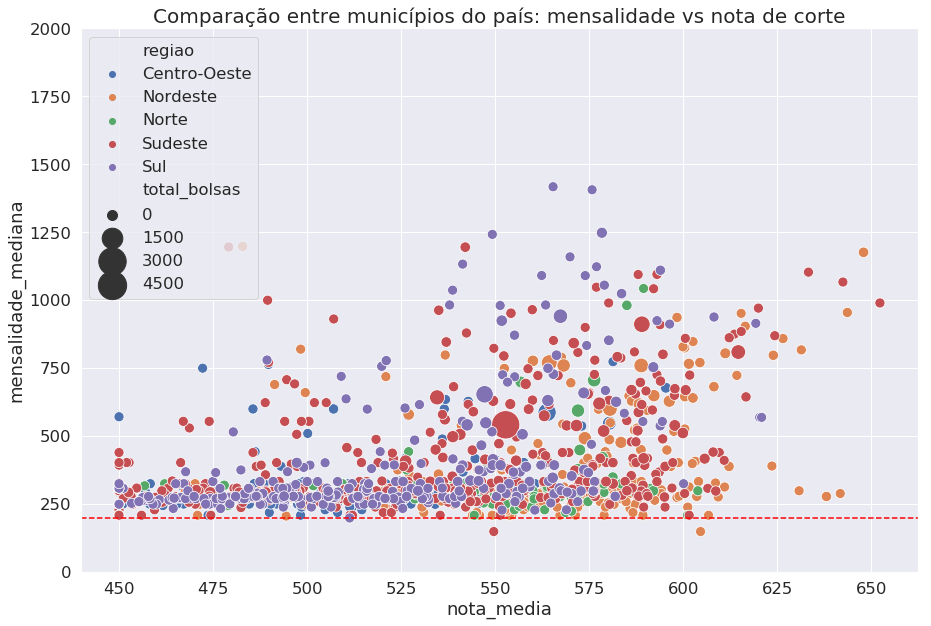

In [290]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))
plt.title('Comparação entre municípios do país: mensalidade vs nota de corte', size=20)

sns.scatterplot(x='nota_media', y='mensalidade_mediana',
                data=comp_cidades,
                sizes=(100, 800),
                hue='regiao',
                size='total_bolsas', 
                legend='brief')

plt.axhline(y=200, color='red', ls='--')
plt.ylim(0, 2000)
plt.show()

Curiosamente, poucas universidades particulares ultrapassam, para baixo, a "barreira dos R$ 200" de mensalidade (linha vermelha tracejada).

In [157]:
mean_cidades = df.groupby('cidade_busca').mean().reset_index()
mean_cidades.head()

,cidade_busca,mensalidade,bolsa_integral_cotas,bolsa_integral_ampla,bolsa_parcial_cotas,bolsa_parcial_ampla,nota_integral_ampla,nota_integral_cotas,nota_parcial_ampla,nota_parcial_cotas
0,Abaete,333.000000,1.0,1.0,NaN,NaN,490.287059,495.64,NaN,NaN
1,Abaetetuba,308.000000,3.0,1.0,NaN,NaN,594.610000,587.77,NaN,NaN
2,Abaira,209.000000,2.0,NaN,NaN,NaN,470.880000,NaN,NaN,NaN
3,Abelardo Luz,259.833333,0.0,1.0,NaN,1.0,450.000000,NaN,457.816364,NaN
4,Acailandia,289.000000,1.0,NaN,NaN,NaN,641.760000,NaN,NaN,NaN


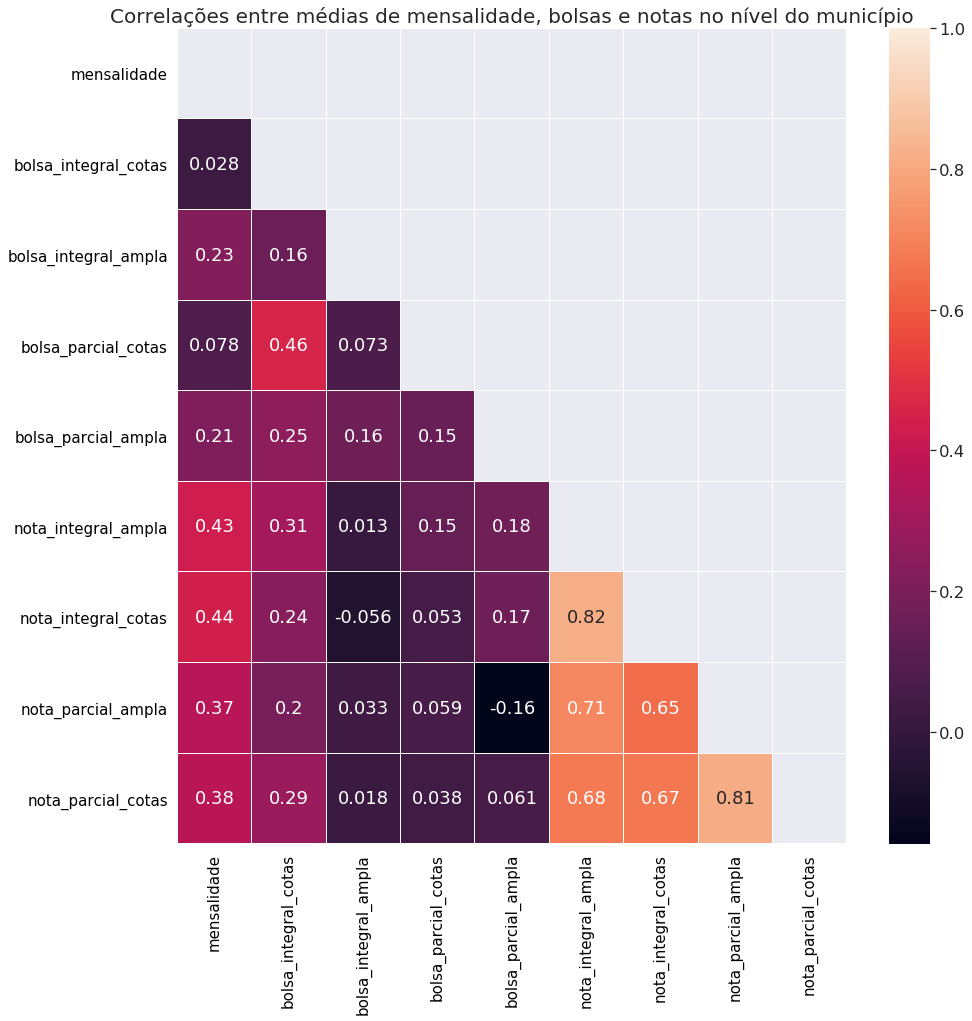

In [158]:
sns.set(font_scale=1.5)
mask = np.zeros_like(mean_cidades.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 15))
plt.title('Correlações entre médias de mensalidade, bolsas e notas no nível do município', size=20)
sns.heatmap(mean_cidades.corr(), mask=mask, annot=True, linecolor='white', linewidths=0.1)
plt.xticks(color='black', size=15, rotation=90)
plt.yticks(color='black', size=15)
plt.show()

## Comparando extremos

Sabemos (\*) que Goiás tem o melhor Ideb (relação entre fluxo e aprendizado) entre os estados do país no ensino médio, **4.3**. Na outra ponta, a Bahia tem o pior Ideb, **2.7**. Como as universidades desses dois extremos se comparam quanto aos dados do Prouni?  

Pelo pairplot abaixo, apesar da enorme diferença entre aprovações e notas médias na fase que precede o ensino superior nos dois estados, podemos notar que isso pouco se expressa, diferencia, na quantida de bolsas oferecidas pelas universidades particulares de cada estado, bem como nas mensalidades e notas médias, o que pode representar uma assimetria de tratamentos que, no limite, tenderia a prolongar, para depois da educação básica, as diferenças educacionais entre as macrorregiões do país.

<br></br>
\* Fonte: https://www.qedu.org.br/brasil/ideb/ideb-por-estados?dependence=2&grade=3&edition=2017

<Figure size 2160x2160 with 0 Axes>

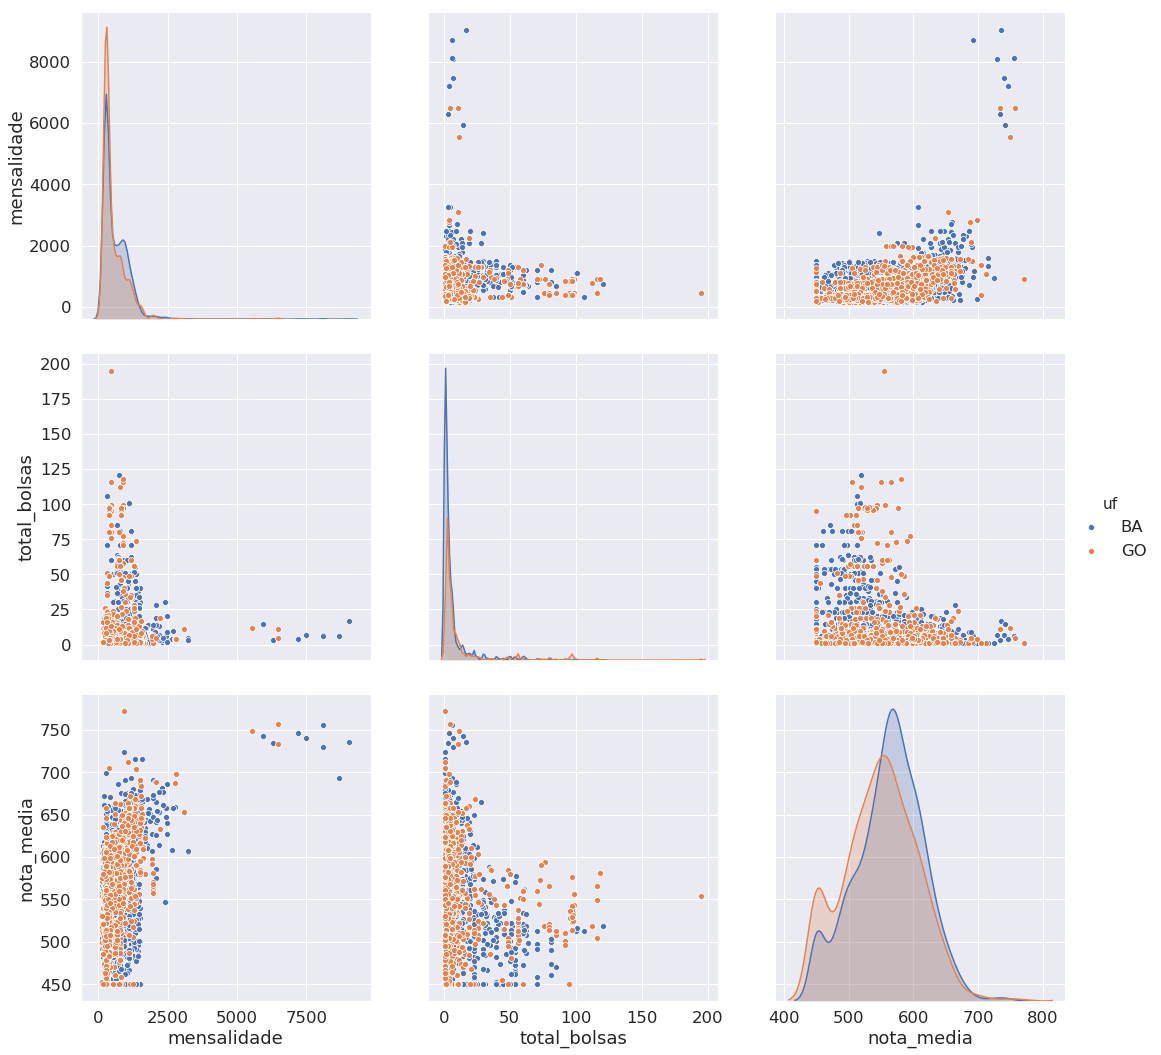

In [303]:
plt.figure(figsize=(30, 30))

sns.pairplot(dfmin.loc[dfmin['uf'].isin(['GO', 'BA'])], 
             diag_kind='kde', 
             hue='uf', 
             height=5)
plt.show()

# 4. Outras informações úteis

Do ponto de vista da universidade, ter informações de retenção ou churn, etc., de todos os alunos seria muito útil para avaliar o impacto no longo prazo de cada tipo de bolsa (considerando aqui como um custo de aquisição trazido para o presente) e nota de corte.

Do lado do governo, ver essas variáveis projetadas ao longo dos últimos anos poderia ajudar a entender se estamos evoluindo ou não no programa.

# 5. Possíveis aplicações
Para as faculdades, no desenho de estratégias de expansão - vide análises regionais, indicando uma possível oportunidade no nordeste, por exemplo.

Em termos de políticas públicas, pode ajudar o governo a perceber e elucidar assimetrias de investimento em estados e regiões bastante desiguais, como por exemplo entre GO e BA - locais que poderiam receber investimentos diferentes também.